# 1. Helper functions
Just for convieniece we will create a helper class which contains functions used many times in the notebook

In [1]:
import zipfile
import numpy as np

In [2]:
class Helper():
  def unnormalize(self, img, mean, std):
    image = img.detach().cpu()
    image = img.numpy().transpose((1, 2, 0))
    image = image * std + mean
    image = np.clip(image, 0, 1)
    return image

  def unzip(self, file_path, dir):
    print("Unzipping...")
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
      zip_ref.extractall(dir)

In [3]:
helper = Helper()

# 2. Dataset
The dataset we will use is the [CelebA](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset) dataset with 200,000 images.

## Kaggle
We will use kaggle to download the dataset.

NOTE: You will need a kaggle.json file.

In [4]:
from google.colab.files import upload

In [5]:
print("Installing kaggle")
!pip install kaggle -q
print("Upload kaggle.json")
upload()
print("Setting kaggle up...")
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!rm -fr sample_data
print("Done!")

Installing kaggle
Upload kaggle.json


Saving kaggle.json to kaggle.json
Setting kaggle up...
Done!


## Downloading dataset


In [8]:
import os, glob, zipfile

In [9]:
data_labels_filename = "bbox_labels.csv"
data_inputs_foldername = "images"
data_foldername = "data"

In [10]:
if not os.path.exists(data_foldername):
  !kaggle datasets download -d jessicali9530/celeba-dataset

  if not os.path.exists(data_foldername): os.mkdir(data_foldername)
  helper.unzip("celeba-dataset.zip", data_foldername)

  os.rename("data/img_align_celeba", f"data/{data_inputs_foldername}")
  os.rename("data/list_bbox_celeba.csv", f"data/{data_labels_filename}")

  os.remove("celeba-dataset.zip")

  print("Done!")

 99% 1.32G/1.33G [00:10<00:00, 140MB/s]
100% 1.33G/1.33G [00:10<00:00, 135MB/s]
Unzipping...
Done!


## Cleaning file structure

In [11]:
import shutil

In [12]:
# Removing unnecessary
for filepath in glob.glob("data/*.csv"):
  if filepath != os.path.join("data", data_labels_filename):
    os.remove(filepath)

In [13]:
# Getting the actual image folder
os.chdir("data")
shutil.move("images/img_align_celeba", "./")
os.rmdir(data_inputs_foldername)
os.rename("img_align_celeba", data_inputs_foldername)
os.chdir("../")

## Splitting into train and valid datasets
We will have three different split:

* Labels split: The labels for inputs
* Filenames split: The filenames for our inputs. (Removed from labels to keep datatypes consistent)
* Inputs split: The images split

All of the above are split into train and valid

In [14]:
from tqdm.notebook import tqdm
import pandas as pd

### Labels split

In [15]:
df = pd.read_csv("data/bbox_labels.csv")
df.rename(columns={"image_id": "name"}, inplace=True)
filename_df = df["name"]
df.drop("name", inplace=True, axis=1)
df.head()

,x_1,y_1,width,height
0,95,71,226,313
1,72,94,221,306
2,216,59,91,126
3,622,257,564,781
4,236,109,120,166


In [16]:
y_train, y_valid = np.split(df, [int(0.8 * len(df))])
y_train, y_valid = y_train.values, y_valid.values

In [17]:
len(y_train), len(y_valid)

(162079, 40520)

### Filenames split

In [18]:
filename_df.head()

0    000001.jpg
1    000002.jpg
2    000003.jpg
3    000004.jpg
4    000005.jpg
Name: name, dtype: object

In [19]:
f_train, f_valid = np.split(filename_df, [int(0.8 * len(df))])
f_train, f_valid = f_train.values, f_valid.values

In [20]:
len(f_train), len(f_valid)

(162079, 40520)

### Inputs split

In [21]:
for foldername in ["train", "valid"]:
  if not os.path.exists(f"data/{foldername}"):
    os.mkdir(f"data/{foldername}")

In [22]:
images_filenames = sorted(os.listdir("data/images"))
images = []

for i, filename in enumerate(tqdm(images_filenames)):
  if i < int(0.8 * len(images_filenames)):
    shutil.move(f"data/images/{filename}", f"data/train/{filename}")
  else:
    shutil.move(f"data/images/{filename}", f"data/valid/{filename}")

os.rmdir("data/images")

  0%|          | 0/202599 [00:00<?, ?it/s]

In [23]:
len(os.listdir("data/train")), len(os.listdir("data/valid")) 

(162079, 40520)

In [24]:
f_train == sorted(os.listdir("data/train"))

array([ True,  True,  True, ...,  True,  True,  True])

## Dataset class
Because we are working with files as input and dataframes as labels there are no pre-built functions in pytorch for this, so we will create our own.


In [25]:
from torch.utils.data import Dataset
import torch
import PIL

In [26]:
class CSVDataset(Dataset):
    def __init__(self, root_dir, y, f, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.y = y
        self.f = f

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.f[idx])
        image = PIL.Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        label = torch.from_numpy(self.y[idx, :])
        return image, label

## Creating and loading dataset

In [27]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms

In [28]:
img_size = 256
batch_size = 64
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [29]:
transformations = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [30]:
train_dir = "data/train"
valid_dir = "data/valid"

In [31]:
train_ds = CSVDataset(train_dir, y_train, f_train, transform=transformations)
valid_ds = CSVDataset(valid_dir, y_valid, f_valid, transform=transformations)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

## Displaying images

In [32]:
import matplotlib.pyplot as plt

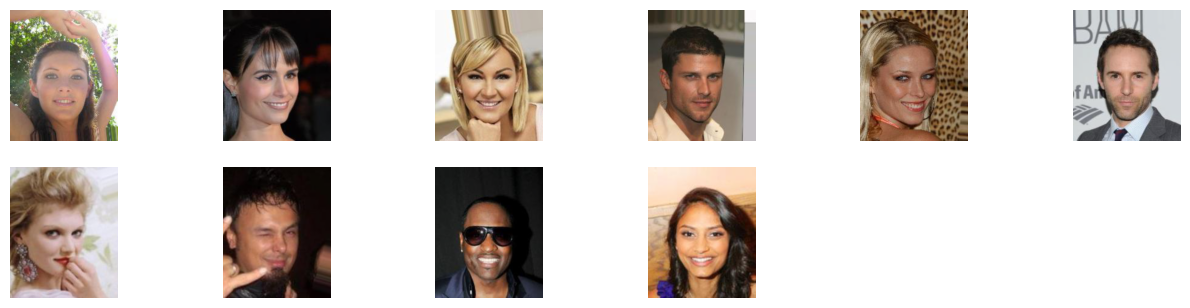

In [45]:
num_examples = 10
X, y = next(iter(train_dl))

figure = plt.figure(figsize=(16,16))

for i in range(10):
  plt.subplot(8,6,i+1)
  img_T = helper.unnormalize(X[i], mean, std)
  plt.imshow(img_T)
  plt.axis("off")
  
plt.show()